# Bibliotecas

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model, tree, ensemble
from sklearn.utils import shuffle
import umap.umap_ as umap
import hdbscan
import math
import pickle

# Obtenção dos dados de índice de refração já pré-processados (dados_nd)

In [3]:
dados_nd_train = pd.read_csv("data_nd_train.csv")
dados_nd_test = pd.read_csv("data_nd_test.csv")
print(dados_nd_train)
print(dados_nd_test)

             Li   Be         B         O        Na   Mg        Al        Si  \
0      0.164384  0.0  0.136986  0.554795  0.000000  0.0  0.041096  0.102740   
1      0.209646  0.0  0.089954  0.516141  0.000000  0.0  0.184258  0.000000   
2      0.041708  0.0  0.017901  0.604843  0.127084  0.0  0.000000  0.000000   
3      0.000000  0.0  0.000000  0.669367  0.000000  0.0  0.000000  0.000000   
4      0.110769  0.0  0.000000  0.636923  0.000000  0.0  0.000000  0.000000   
...         ...  ...       ...       ...       ...  ...       ...       ...   
37644  0.000000  0.0  0.032357  0.606523  0.000000  0.0  0.000000  0.223220   
37645  0.211679  0.0  0.090853  0.525591  0.008017  0.0  0.013235  0.111122   
37646  0.000000  0.0  0.000000  0.622554  0.000000  0.0  0.000000  0.000000   
37647  0.000000  0.0  0.000000  0.583743  0.111216  0.0  0.000000  0.198854   
37648  0.000000  0.0  0.093081  0.662012  0.000000  0.0  0.000000  0.000000   

              P         K  ...   Hf   Ta         W 

# Regressor geral - Hold out

## Treino

In [4]:
X_train = dados_nd_train.iloc[:,0:-1].values
y_train = dados_nd_train.iloc[:,-1].values
print("Matrix of features", X_train, sep='\n')
print("--------------------------------------------------")
print("Target Variable", y_train, sep='\n')
print(X_train.shape)
print(y_train.shape)

Matrix of features
[[0.1643836  0.         0.1369863  ... 0.         0.         0.        ]
 [0.20964619 0.         0.08995413 ... 0.         0.         0.        ]
 [0.04170822 0.         0.01790146 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.09308147 ... 0.         0.         0.        ]]
--------------------------------------------------
Target Variable
[1.551 1.539 1.686 ... 1.89  1.601 1.89 ]
(37649, 65)
(37649,)


## Teste

In [5]:
X_test = dados_nd_test.iloc[:,0:-1].values
y_test = dados_nd_test.iloc[:,-1].values
print("Matrix of features", X_test, sep='\n')
print("--------------------------------------------------")
print("Target Variable", y_test, sep='\n')
print(X_test.shape)
print(y_test.shape)

Matrix of features
[[0.         0.         0.07388025 ... 0.         0.         0.        ]
 [0.03894426 0.         0.27245755 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.28008179 ... 0.         0.         0.        ]
 [0.         0.         0.0621383  ... 0.         0.         0.        ]
 [0.         0.         0.05040692 ... 0.         0.         0.        ]]
--------------------------------------------------
Target Variable
[1.809 1.692 1.661 ... 1.757 1.696 1.652]
(9413, 65)
(9413,)


# Regressão geral - Gradient Boosting
- 17/11/2023: Adicionei essa abordagem de regressão

In [6]:
general_scores = []
general_mads = []
general_rmses = []

print("Regressão geral")
reg_geral = GradientBoostingRegressor()
reg_geral.fit(X_train, y_train)

# Cálculo do MAE
prediction = reg_geral.predict(X_test)
dif_module = abs(prediction - y_test)
mad = dif_module.mean()
general_mads.append(mad)
print("MAE: ", mad)

# Cálculo de RMSE
residual = ((y_test - prediction)** 2).mean()
rmse = np.sqrt(residual)
general_rmses.append(rmse)
print("RMSE: ", rmse)

# Cálculo do score
score = reg_geral.score(X_test, y_test)
general_scores.append(score)
print(f"Regressor geral: {score}")

# Erro
error_data_frame = pd.DataFrame(dif_module)
error_description = error_data_frame.describe()
print("Descrição do erro no teste:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(error_description.transpose())

Regressão geral
MAE:  0.033279182806808305
RMSE:  0.05476590004353088
Regressor geral: 0.9152763354662472
Descrição do erro no teste:
    count      mean       std       min       25%       50%       75%  \
0  9413.0  0.033279  0.043497  0.000002  0.010489  0.022123  0.041395   

        max  
0  0.867368  


# Regressão geral - Hist Gradient Boosting
- 17/11/2023: Adicionei essa abordagem de regressão

In [18]:
hist_grad_boost = HistGradientBoostingRegressor()
hist_grad_boost.fit(X_train, y_train)

Regressão geral


HistGradientBoostingRegressor()

## Automação para __Hyperparameter tuning__

In [35]:
models = {
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        loss = 'poisson', learning_rate=0.4, max_leaf_nodes=31, random_state=0, early_stopping=False
    ),
}

param_grids = {
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500, 1000]},
}

cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

In [36]:
print(results)

[{'model': 'Hist Gradient Boosting', 'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.679031      0.205494         0.010956        0.004542   
1       1.504051      0.093445         0.035718        0.010328   
2       2.718445      0.076596         0.050248        0.007142   
3       4.869752      0.152405         0.067059        0.008836   
4      13.587698      0.421154         0.365757        0.275002   
5      23.130352      2.653491         0.295062        0.062614   
6      41.715859      0.932924         0.507220        0.026843   

  param_max_iter              params  split0_test_score  split1_test_score  \
0             10    {'max_iter': 10}           0.916727           0.923572   
1             20    {'max_iter': 20}           0.930582           0.936883   
2             50    {'max_iter': 50}           0.944056           0.948912   
3            100   {'max_iter': 100}           0.949225           0.954628   
4            300   {'m

In [44]:
general_scores = []
general_mads = []
general_rmses = []

print("Regressão geral")
reg_geral = HistGradientBoostingRegressor(loss = 'poisson', max_iter = 5000, max_leaf_nodes=50, random_state=0, early_stopping=False)
reg_geral.fit(X_train, y_train)

# Cálculo do score
score = reg_geral.score(X_test, y_test)
general_scores.append(score)
print(f"Regressor geral: {score}")

# Cálculo do MAE
prediction = reg_geral.predict(X_test)
dif_module = abs(prediction - y_test)
mad = dif_module.mean()
general_mads.append(mad)
print("MAE: ", mad)

# Cálculo de RMSE
residual = ((y_test - prediction)** 2).mean()
rmse = np.sqrt(residual)
general_rmses.append(rmse)
print("RMSE: ", rmse)

# Erro
error_data_frame = pd.DataFrame(dif_module)
error_description = error_data_frame.describe()
print("Descrição do erro no teste:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(error_description.transpose())

Regressão geral
Regressor geral: 0.9718097212692267
MAE:  0.013228011382653617
RMSE:  0.03159057627948969
Descrição do erro no teste:
    count      mean       std           min       25%       50%       75%  \
0  9413.0  0.013228  0.028689  7.701276e-07  0.002099  0.005475  0.013146   

        max  
0  1.000383  


# Comparação entre Random Forest e Hist Gradient Boosting

In [46]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 4


In [54]:
models = {
    "Random Forest": RandomForestRegressor(
        max_features='sqrt', random_state=0, n_jobs=N_CORES
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        loss = 'poisson', max_iter = 5000, max_leaf_nodes=50, random_state=0, early_stopping=False
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [390]},
    "Hist Gradient Boosting": {"max_iter": [10000]},
}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X_train, y_train)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

In [55]:
print(results)

[{'model': 'Random Forest', 'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      28.051937      2.197594         0.691406        0.232654   

  param_n_estimators                 params  split0_test_score  \
0                390  {'n_estimators': 390}           0.960659   

   split1_test_score  split2_test_score  split3_test_score  mean_test_score  \
0           0.967828           0.959042           0.968348         0.963969   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.004162                1            0.993594            0.992517   

   split2_train_score  split3_train_score  mean_train_score  std_train_score  
0            0.993254            0.992407          0.992943         0.000497  }, {'model': 'Hist Gradient Boosting', 'cv_results':    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0     581.933903      3.803701         5.113762        0.371593   

  param_max_iter             

# Regressão geral - Random Forest

In [8]:
general_scores = []
general_mads = []
general_rmses = []

print("Regressão geral")
reg_geral = ensemble.RandomForestRegressor(n_estimators=390, max_features='sqrt')
reg_geral.fit(X_train, y_train)

# Cálculo do MAE
prediction = reg_geral.predict(X_test)
dif_module = abs(prediction - y_test)
mad = dif_module.mean()
general_mads.append(mad)
print("MAE: ", mad)

# Cálculo de RMSE
residual = ((y_test - prediction)** 2).mean()
rmse = np.sqrt(residual)
general_rmses.append(rmse)
print("RMSE: ", rmse)

# Cálculo do score
score = reg_geral.score(X_test, y_test)
general_scores.append(score)
print(f"Regressor geral: {score}")

# Erro
error_data_frame = pd.DataFrame(dif_module)
error_description = error_data_frame.describe()
print("Descrição do erro no teste:")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(error_description.transpose())

Regressão geral
MAE:  0.01391001996610951
RMSE:  0.03248098109218468
Regressor geral: 0.9701981962506351
Descrição do erro no teste:
    count     mean       std           min       25%       50%       75%  \
0  9413.0  0.01391  0.029353  1.998401e-15  0.001908  0.005563  0.014189   

        max  
0  0.742866  


# Residual plot
Esse gráfico pode mostrar se há algum padrão nos erros, indicando que que o modelo não está capturando algumas informações importantes dos dados.

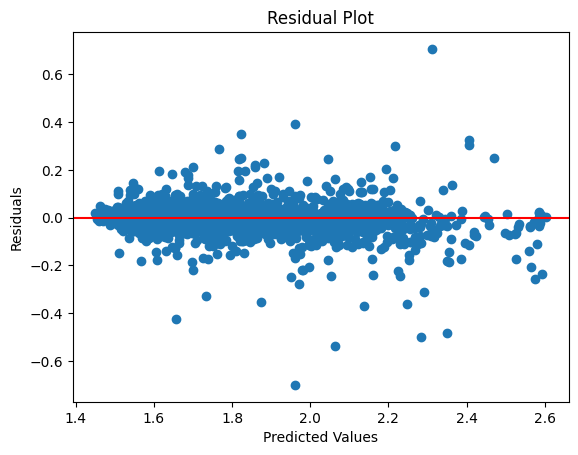

In [6]:
residuals = prediction - y_test
plt.scatter(prediction, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Residual Plot')
plt.show()

# Histogram of residuals
Indica se a distribuição é aproximadamente normal ou se há outliers ou alguma assimetria.

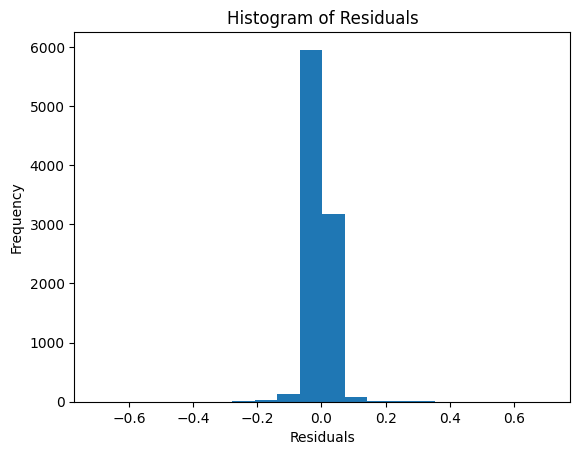

In [7]:
plt.hist(residuals, bins=20)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

# Scale-Location Plot
Esse gráfico pode mostrar se há uma relação não linear entre os erros e os valores preditos. Se os pontos seguirem uma distribuição normal, se espera ver pontos distribuídos aleatoriamente ao longo da linha horizontal.

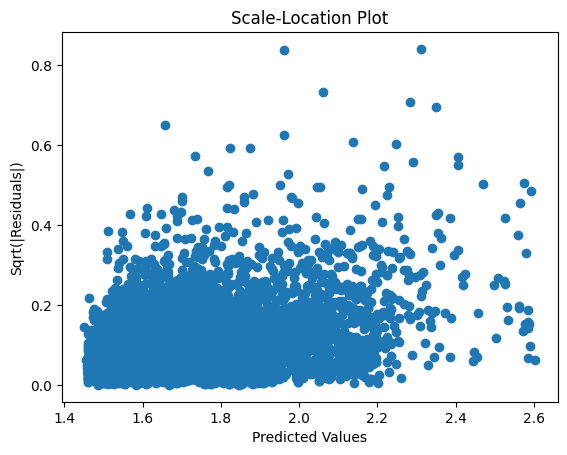

In [8]:
# calculate the absolute square root of the residuals 
sqrt_abs_resid = np.sqrt(dif_module) 

# plot the square root of the absolute residuals against the predicted values 
plt.scatter(prediction, sqrt_abs_resid) 
plt.title("Scale-Location Plot") 
plt.xlabel("Predicted Values") 
plt.ylabel("Sqrt(|Residuals|)") 
plt.show()

# Q-Q Plot
Compara o modelo com uma distribuição normal, se os dados seguem uma distribuição normal, eles devem seguir a linha reta

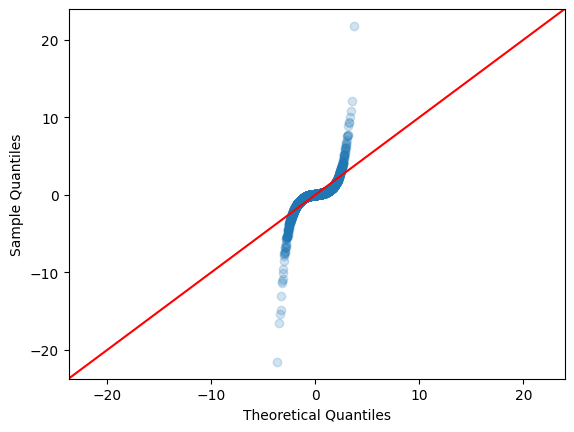

In [9]:
import statsmodels.api as sm

# create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(residuals, fit=True, line="45", alpha=0.2)
plt.show()

# Actual vs Predicted Plot

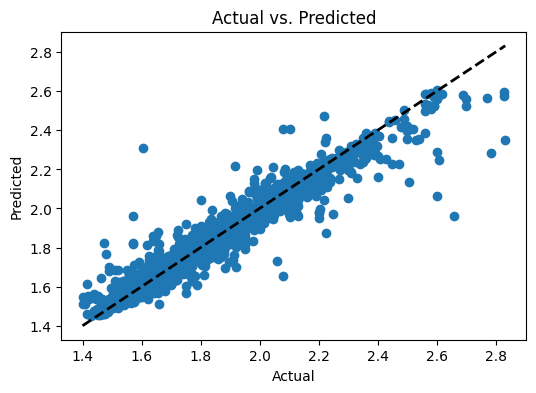

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Plot the actual vs. predicted values
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(y_test, prediction)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Actual vs. Predicted")
plt.show()

# Tabela dos vidros que erram acima da média do erro

In [68]:
elementos = []
for i in dados_nd_test:
    elementos.append(i)
elementos_df = pd.DataFrame(elementos)
elementos_df = elementos_df.T
elementos_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,ND300


In [69]:
objeto = dados_nd_test.values.tolist()
for linha,coluna in enumerate(objeto):
    pass
objeto = pd.DataFrame(coluna)
objeto = objeto.T
objeto

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.0,0.0,0.050407,0.626828,0.0,0.0,0.108672,0.133013,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.652


In [70]:
frames = [elementos_df,objeto]
pontos_erro = pd.concat(frames, axis = 0, join = 'inner')
pontos_erro = pontos_erro[0:1]
pontos_erro

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,ND300


In [71]:
dif_module.mean()

0.013909683587514184

In [72]:
dif_module_mean = dif_module.mean()
dif_maior_que_media = []
for i,dif in enumerate(dif_module):
    if dif >= dif_module_mean:
        dif_maior_que_media.append(dif)
        objeto = dados_nd_test[i:i+1][:].values.tolist()
        for linha,coluna in enumerate(objeto):
            pass
        objeto = pd.DataFrame(coluna)
        objeto = objeto.T
        pontos_erro = pd.concat([pontos_erro,objeto], axis = 0, join='inner')
pontos_erro

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Hf,Ta,W,Hg,Tl,Pb,Bi,Th,U,ND300
0,0.092745,0.0,0.179135,0.570236,0.00559,0.0,0.047567,0.072071,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.58
0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,2.218
0,0.0,0.0,0.0,0.692308,0.0,0.0,0.0,0.0,0.230769,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.559
0,0.0,0.0,0.363636,0.590909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0,1.787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.176302,0.0,0.11658,0.54084,0.008488,0.0,0.0,0.116789,0.0,0.002395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.586
0,0.0,0.0,0.0,0.655172,0.103448,0.0,0.0,0.0,0.158621,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.712
0,0.0,0.0,0.0,0.680271,0.025763,0.0,0.01566,0.0,0.243729,0.0,...,0.0,0.0,0.0,0.0,0.0,0.034577,0.0,0.0,0.0,1.58
0,0.0,0.0,0.0,0.62963,0.0,0.0,0.0,0.148148,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.78


C:\Users\Alberico\AppData\Local\Temp\ipykernel_9204\2859868940.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pontos_erro['dif'] = dif_maior_que_media


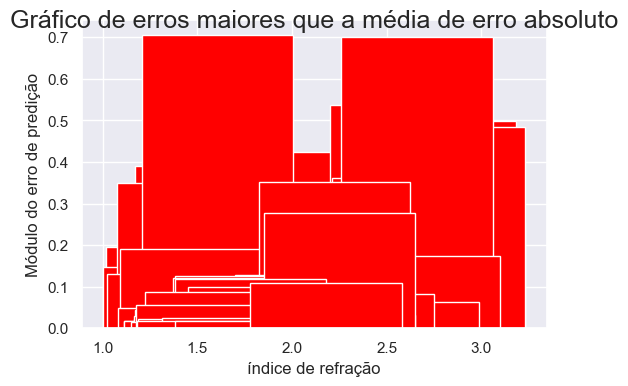

,Li,Be,B,O,Na,Mg,Al,Si,P,K,...,Ta,W,Hg,Tl,Pb,Bi,Th,U,ND300,dif
0,0.092745,0.0,0.179135,0.570236,0.005590,0.0,0.047567,0.072071,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.580,0.019250
0,0.000000,0.0,0.000000,0.600000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.200000,0.000000,0.0,0.0,2.218,0.056578
0,0.000000,0.0,0.000000,0.692308,0.000000,0.0,0.000000,0.000000,0.230769,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.559,0.048458
0,0.000000,0.0,0.363636,0.590909,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.022727,0.000000,0.0,0.0,1.787,0.178882
0,0.000000,0.0,0.045249,0.591998,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.322741,0.0,0.0,2.370,0.072518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.176302,0.0,0.116580,0.540840,0.008488,0.0,0.000000,0.116789,0.000000,0.002395,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.586,0.021462
0,0.000000,0.0,0.000000,0.655172,0.103448,0.0,0.000000,0.000000,0.158621,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.712,0.023731
0,0.000000,0.0,0.000000,0.680271,0.025763,0.0,0.015660,0.000000,0.243729,0.000000,...,0.0,0.0,0.0,0.0,0.034577,0.000000,0.0,0.0,1.580,0.017859
0,0.000000,0.0,0.000000,0.629630,0.000000,0.0,0.000000,0.148148,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1.780,0.016511


,count,mean,std,min,25%,50%,75%,max
0,,,,,,,,
Li,2439.0,1.448686e-02,0.037656,0.000000,0.000000,0.000000,0.000000,0.348179
Be,2439.0,7.137871e-04,0.008380,0.000000,0.000000,0.000000,0.000000,0.182816
B,2439.0,8.179581e-02,0.104155,0.000000,0.000000,0.015766,0.151813,0.400000
O,2439.0,6.067256e-01,0.035011,0.450200,0.584603,0.603581,0.628605,0.727273
Na,2439.0,1.975060e-02,0.044464,0.000000,0.000000,0.000000,0.011499,0.325157
Mg,2439.0,2.927166e-03,0.014342,0.000000,0.000000,0.000000,0.000000,0.246322
Al,2439.0,1.100545e-02,0.029711,0.000000,0.000000,0.000000,0.000000,0.339076
Si,2439.0,6.148806e-02,0.081487,0.000000,0.000000,0.007728,0.121336,0.324333
P,2439.0,2.542227e-02,0.061741,0.000000,0.000000,0.000000,0.000000,0.270852


In [73]:
# Assign row as column headers
header_row = 0
pontos_erro.columns = pontos_erro.iloc[header_row]

# Convert row to column header using DataFrame.iloc[]
pontos_erro.columns = pontos_erro.iloc[0]
pontos_erro = pontos_erro[1:]

pontos_erro['dif'] = dif_maior_que_media

pontos_erro = pontos_erro.apply(pd.to_numeric)

fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Gráfico de erros maiores que a média de erro absoluto", fontsize=18, y=0.95)
ax.set_xlabel("índice de refração")
ax.set_ylabel("Módulo do erro de predição")
ax.bar(pontos_erro['ND300'], dif_maior_que_media, color='red')
#plt.xticks([0,340,453,566,679,792,905,1018,1131,1244,1357,1470])
#plt.yticks([0,100,200,300,400])
plt.show()

dataset_transposed = pontos_erro.describe()
display(pontos_erro)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(dataset_transposed.transpose())

<BarContainer object of 2439 artists>

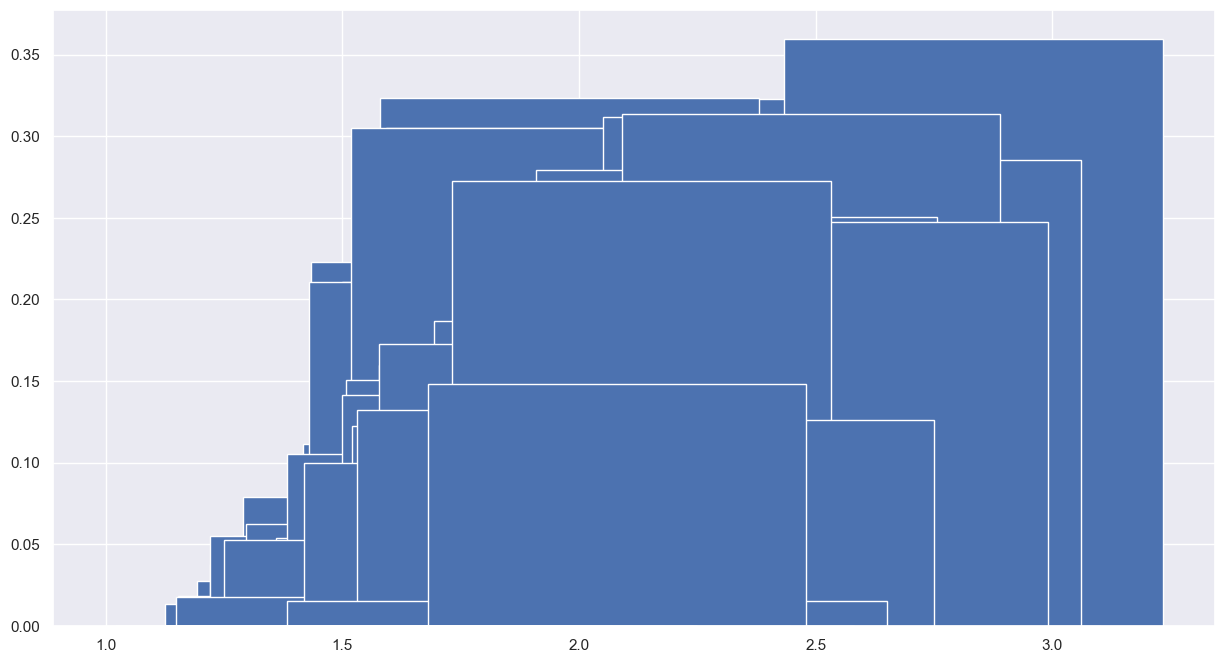

In [47]:
plt.figure(figsize=(15,8))
plt.bar(pontos_erro['ND300'], pontos_erro['Bi'])

# Mapa de correlação

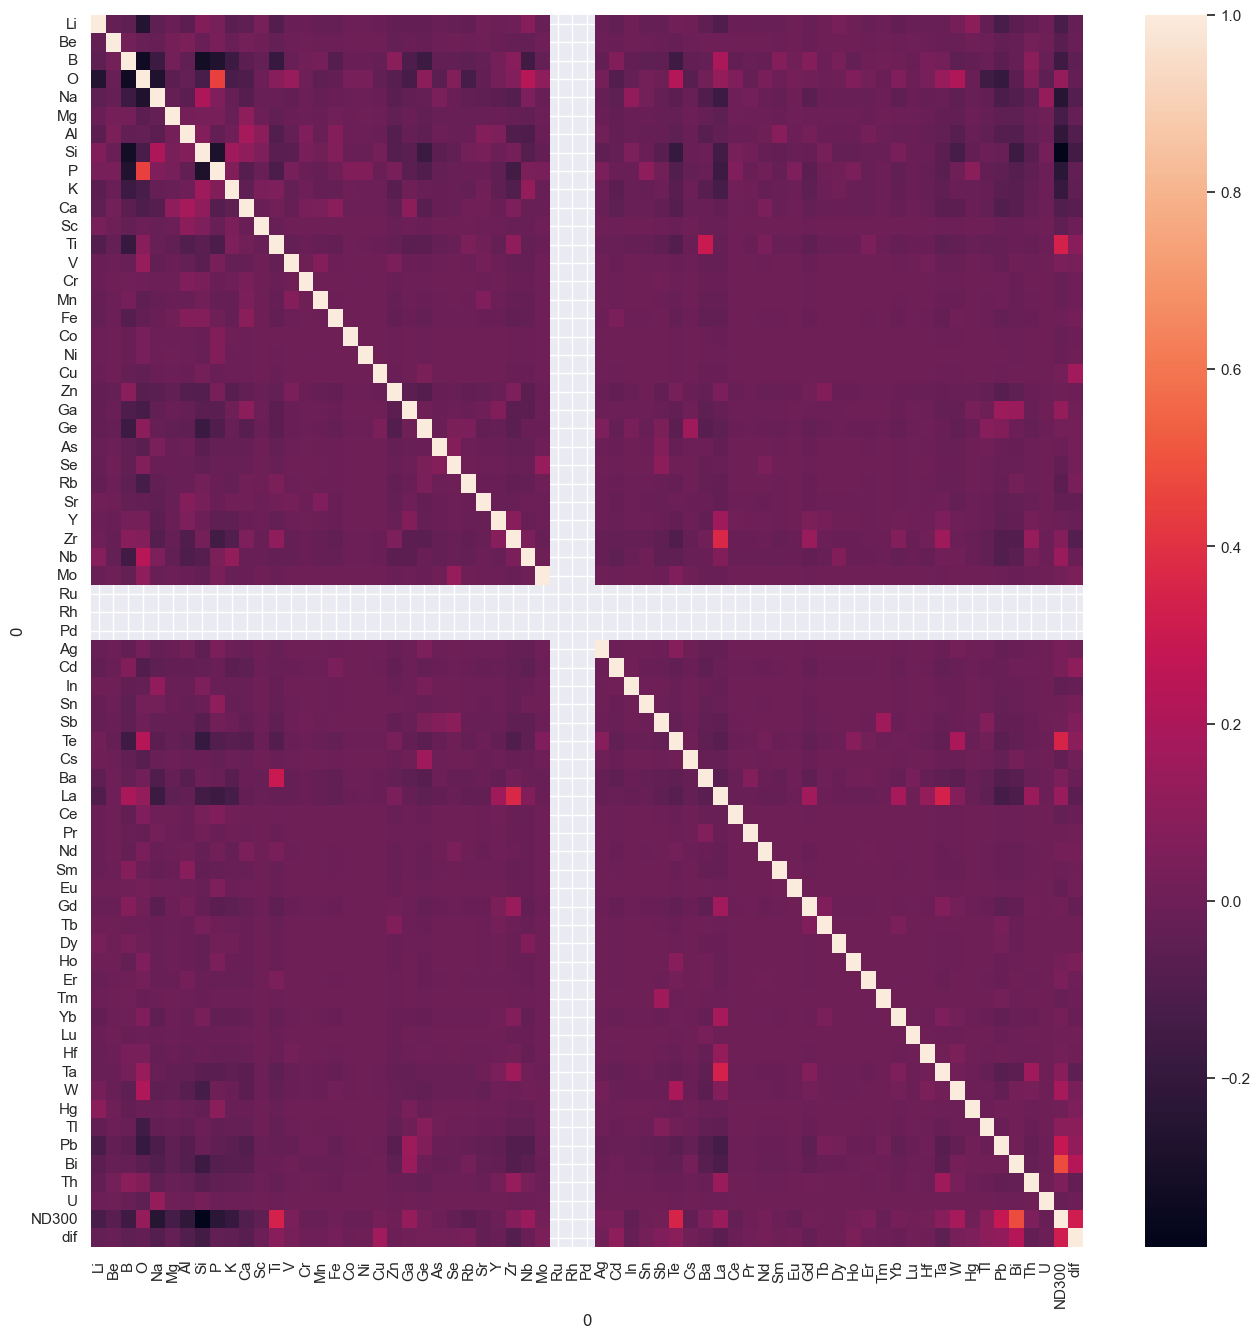

In [48]:
corr = pontos_erro.corr()
heatmap = sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
sns.set (rc = {'figure.figsize':(16, 16)})
plt.show()

# Relação entre Bi e índice de refração

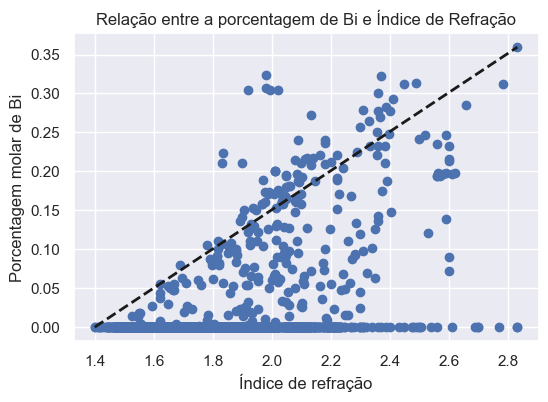

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['ND300'],pontos_erro['Bi'])
ax.plot([pontos_erro['ND300'].min(), pontos_erro['ND300'].max()],[pontos_erro['Bi'].min(), pontos_erro['Bi'].max()], "k--", lw=2)
ax.set_xlabel("Índice de refração")
ax.set_ylabel("Porcentagem molar de Bi")
ax.set_title("Relação entre a porcentagem de Bi e Índice de Refração")
plt.show()

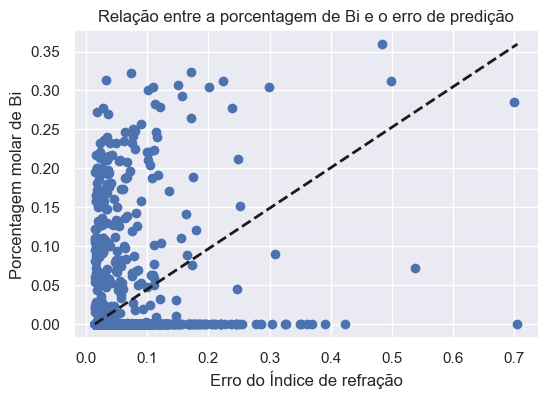

In [74]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['dif'],pontos_erro['Bi'])
ax.plot([pontos_erro['dif'].min(), pontos_erro['dif'].max()],[pontos_erro['Bi'].min(), pontos_erro['Bi'].max()], "k--", lw=2)
ax.set_xlabel("Erro do Índice de refração")
ax.set_ylabel("Porcentagem molar de Bi")
ax.set_title("Relação entre a porcentagem de Bi e o erro de predição")
plt.show()

# Relação entre Si e índice de refração

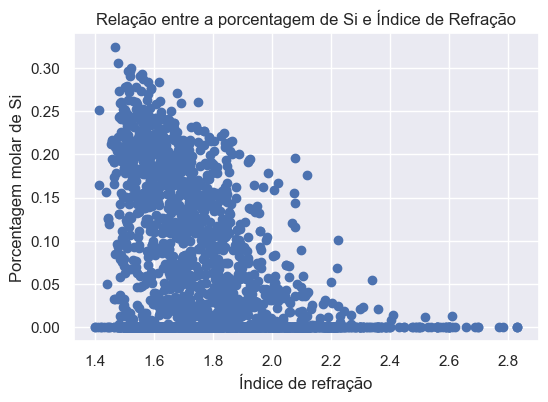

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['ND300'],pontos_erro['Si'])
#ax.plot([pontos_erro['ND300'].min(), pontos_erro['ND300'].max()],[pontos_erro['Si'].min(), pontos_erro['Si'].max()], 'k--', lw=2)
#ax.plot([pontos_erro['ND300'].max(), pontos_erro['Si'].min()], [pontos_erro['ND300'].min(), pontos_erro['Si'].max()], marker='o')
ax.set_xlabel("Índice de refração")
ax.set_ylabel("Porcentagem molar de Si")
ax.set_title("Relação entre a porcentagem de Si e Índice de Refração")
plt.show()

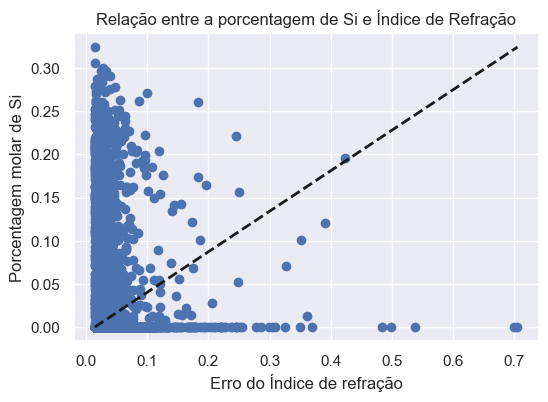

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['dif'],pontos_erro['Si'])
ax.plot([pontos_erro['dif'].min(), pontos_erro['dif'].max()],[pontos_erro['Si'].min(), pontos_erro['Si'].max()], "k--", lw=2)
ax.set_xlabel("Erro do Índice de refração")
ax.set_ylabel("Porcentagem molar de Si")
ax.set_title("Relação entre a porcentagem de Si e Índice de Refração")
plt.show()

# Relação entre P e índice de refração

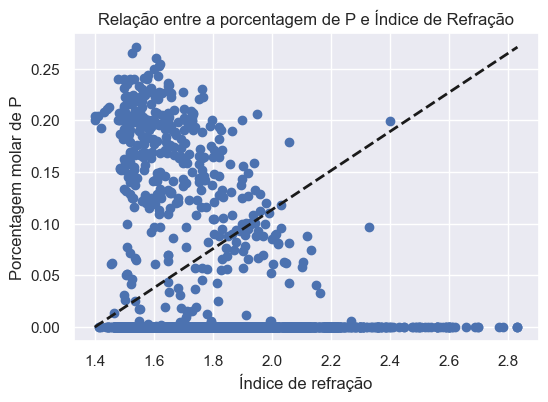

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['ND300'],pontos_erro['P'])
ax.plot([pontos_erro['ND300'].min(), pontos_erro['ND300'].max()],[pontos_erro['P'].min(), pontos_erro['P'].max()], "k--", lw=2)
ax.set_xlabel("Índice de refração")
ax.set_ylabel("Porcentagem molar de P")
ax.set_title("Relação entre a porcentagem de P e Índice de Refração")
plt.show()

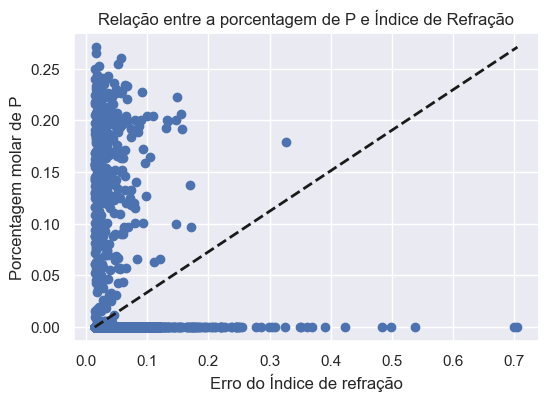

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pontos_erro['dif'],pontos_erro['P'])
ax.plot([pontos_erro['dif'].min(), pontos_erro['dif'].max()],[pontos_erro['Si'].min(), pontos_erro['P'].max()], "k--", lw=2)
ax.set_xlabel("Erro do Índice de refração")
ax.set_ylabel("Porcentagem molar de P")
ax.set_title("Relação entre a porcentagem de P e Índice de Refração")
plt.show()

# Distribuição do índice de refração nos pontos de erro

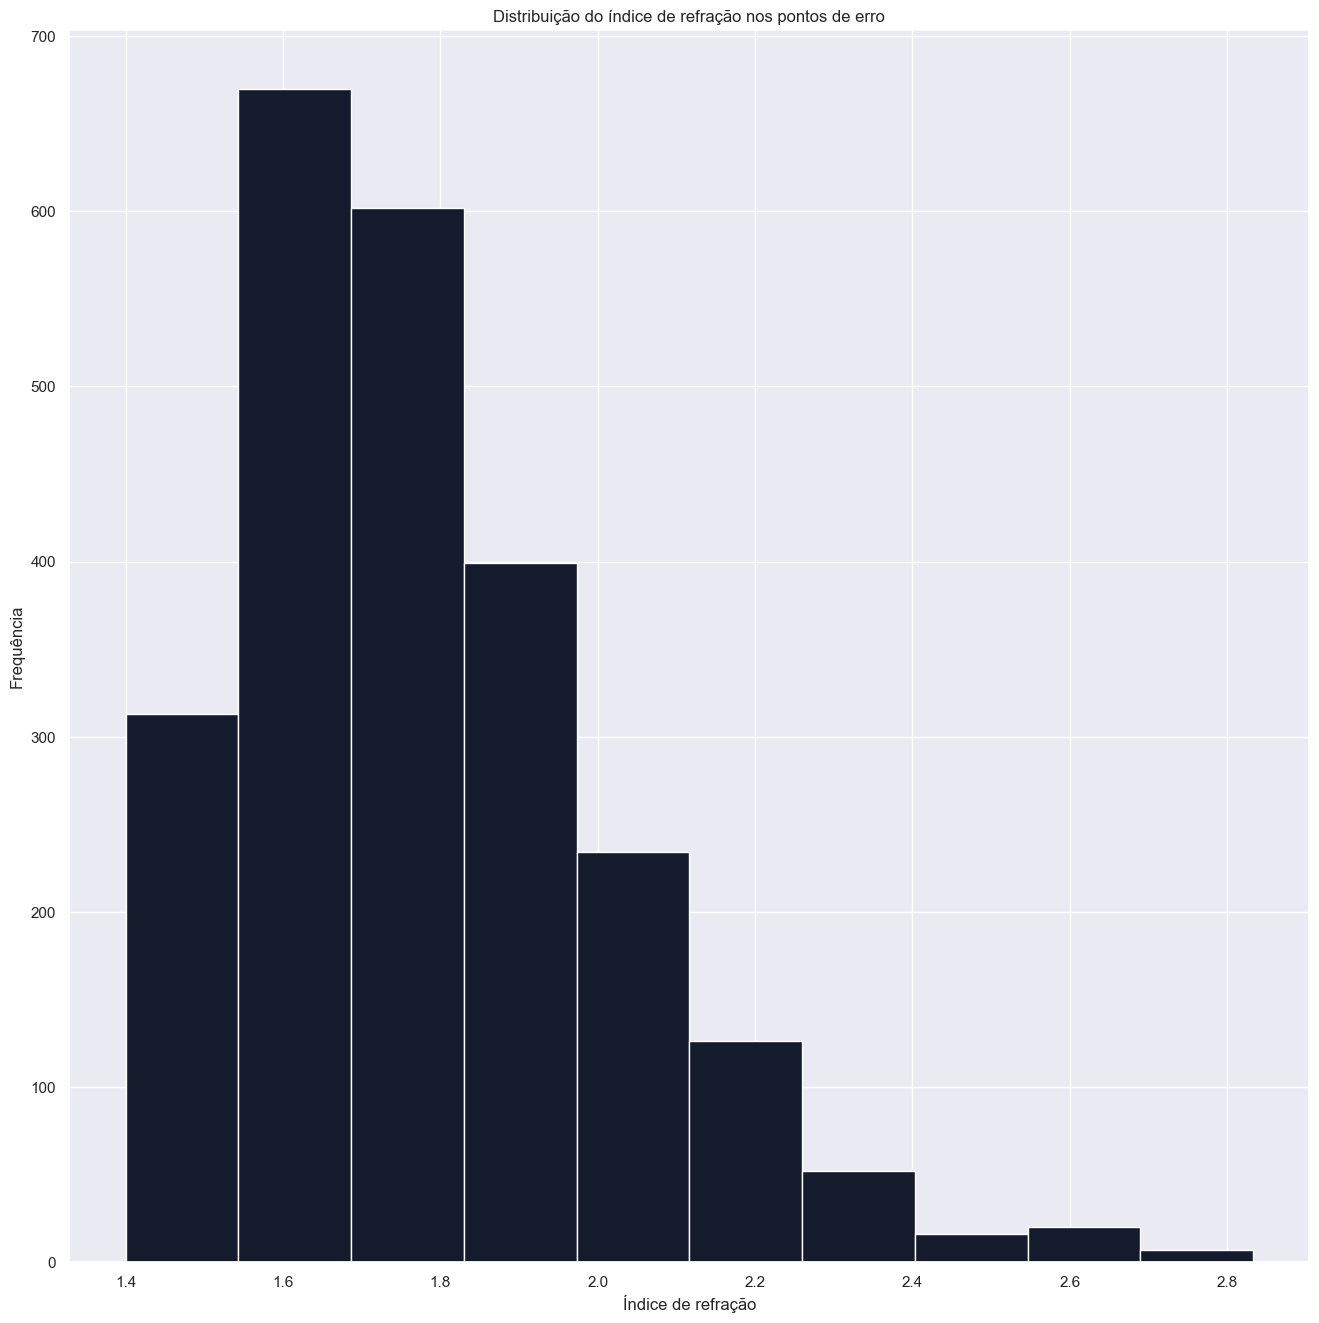

<Figure size 500x500 with 0 Axes>

In [25]:
# Histograma da coluna 'TUE'
pontos_erro['ND300'].plot.hist(color='#131B2C')
plt.xlabel('Índice de refração')
plt.ylabel('Frequência')
plt.title('Distribuição do índice de refração nos pontos de erro')
plt.figure(figsize=(5,5))
plt.show()